In [150]:
import pandas as pd
import numpy as np 
import json
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# Load Train Data Set 

In [2]:
df_tr = pd.read_csv("../res/train.csv")
df_test = pd.read_csv("../res/test.csv")
df_tr.tail()


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False
8692,9280_02,Europa,False,E/608/S,TRAPPIST-1e,44.0,False,126.0,4688.0,0.0,0.0,12.0,Propsh Hontichre,True


In [3]:
df_test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


# Missing Values 

## Home Planet 
A quick analysis of the dataset show that every person in the same group comes from the same home planet. It can be easy to compute to fill the home planet value for unknown 

In [3]:
df_all = pd.concat([df_tr,df_test]).drop(['Transported'], axis=1)
gpId = ExtractGroupId()
gpId.fit_transform(df_all)

NameError: name 'ExtractGroupId' is not defined

In [ ]:
print(f"Before operations, there is {np.sum(df_all.HomePlanet.isna())} records with missing values for Home Planet")
df_home_p = df_all.groupby(['GroupId'])['HomePlanet'].first()
df_all['HomePlanet'] = df_all.apply(lambda row : df_home_p.loc[row['GroupId']] , axis =1)
print(f"After operations, there is {np.sum(df_all.HomePlanet.isna())} records with missing values for Home Planet")

Before operations, there is 288 records with missing values for Home Planet
After operations, there is 157 records with missing values for Home Planet


In [ ]:
# Fill missing values with Unknow Record for Home Planet and Destination
df_all.fillna({'HomePlanet': 'Unknown', 'Destination' : "Unknown"}, inplace=True)

we now have a simple table telling us the Home planet for each group. We use this table to fill the maximum of missing values in the training set. 

In [ ]:
np.sum(df_all.Cabin.isna())

299

In [5]:
df_

NameError: name 'df_' is not defined

In [6]:
np.sum(df_all.groupby('GroupId')['HomePlanet'].nunique() == 0 )

KeyError: 'GroupId'

In [ ]:
df_all[df_all.GroupId == 1]

,PassengerId,GroupId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0001_01,1,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy


In [ ]:
df_tr[df_tr.GroupId == 64]

,PassengerId,GroupId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
58,0064_01,64,Mars,True,F/14/S,TRAPPIST-1e,15.0,False,0.0,0.0,0.0,0.0,0.0,NaN,True
59,0064_02,64,NaN,True,E/3/S,TRAPPIST-1e,33.0,False,0.0,0.0,NaN,0.0,0.0,Colatz Keen,True


In [ ]:
df_gr = df_tr.groupby("GroupId")["HomePlanet"].agg(['unique', 'nunique'])
df_gr[df_gr['nunique'] > 1 ]/

,unique,nunique
GroupId,,


In [7]:
df_tr[df_tr.HomePlanet.isna()]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
59,0064_02,NaN,True,E/3/S,TRAPPIST-1e,33.0,False,0.0,0.0,NaN,0.0,0.0,Colatz Keen,True
113,0119_01,NaN,False,A/0/P,TRAPPIST-1e,39.0,False,0.0,2344.0,0.0,65.0,6898.0,Batan Coning,False
186,0210_01,NaN,True,D/6/P,55 Cancri e,24.0,False,0.0,0.0,NaN,0.0,0.0,Arraid Inicont,True
225,0242_01,NaN,False,F/46/S,TRAPPIST-1e,18.0,False,313.0,1.0,691.0,283.0,0.0,Almone Sté,False
234,0251_01,NaN,True,C/11/S,55 Cancri e,54.0,False,0.0,0.0,0.0,0.0,0.0,Diphah Amsive,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8515,9084_01,NaN,False,E/582/P,TRAPPIST-1e,25.0,False,1258.0,0.0,22.0,19.0,0.0,Jurs Mone,False
8613,9194_01,NaN,False,E/603/S,55 Cancri e,53.0,False,0.0,4017.0,0.0,13.0,3147.0,NaN,False
8666,9248_01,NaN,False,F/1792/S,55 Cancri e,38.0,NaN,28.0,1208.0,973.0,207.0,0.0,Gian Perle,True
8674,9257_01,NaN,False,F/1892/P,TRAPPIST-1e,13.0,False,39.0,0.0,1085.0,24.0,0.0,Ties Apple,False


# Methodology vanilla version 
Looking at the data from dicovery, we will start on assumption that some information might not be relevant for the algorithm to work, such as VIP RoomService, FoodCourt, ShoppingMall, Spa, VRDeck and Name. We will extract the Group ID information from the Passenger ID information and split the Cabin information in Deck Num Side. We will them one hot encode all the information (with training and testing data) and use an trainign algorithm (start with random forest) from there.  

In [4]:
# Init a dataset
df_tr2 = df_tr.copy()

# Extract Group ID information 
We know from the description that PassengerID take the form <code>gggg_pp</code> where : 
- <code>gggg</code> group number with who the passenger is travelling with
- <code>pp</code> Id of this person in the group

We will not be interested by the Person Id within the group, but the group number could be an useful information as it will allow us to cluster Passenger together. It might not be surprising to have passenger in the same group having a higher chance to be in the same final category (meaning Transported or not transported). 

In [5]:
class ExtractGroupId(BaseEstimator, TransformerMixin): 
    def __init__(self) -> None:
        self.src_col = 'PassengerId'
        super().__init__()
    
    def fit(self, X, y=None): 
        return self 
    
    def transform(self, X, y=None):
        index_source_col = X.columns.get_indexer([self.src_col])[0]
        parse_data = X[self.src_col].str.split("_", n=1 , expand = True)
        X.insert(int(index_source_col) + 1, "GroupId", parse_data[0].apply(int))
        X = X.drop(columns = self.src_col)
        return X

# Extract Cabin info information

In [114]:
class ExtractCabinInfo(BaseEstimator,TransformerMixin):
    def __init__(self) -> None:
        self.src_col = 'Cabin'
        super().__init__()
    
    def fit(self, X, y=None): 
        return self
    
    def transform(self, X , y=None): 
        index_source_col = X.columns.get_indexer([self.src_col])[0]
        parse_data = X[self.src_col].str.split("/", n=3 , expand = True)
        X.insert(int(index_source_col) + 1, "Deck", parse_data[0])
        X.insert(int(index_source_col) + 2, "Num", parse_data[1])
        X.insert(int(index_source_col) + 3, "Side", parse_data[2])
        X['Num'] = X['Num'].fillna(-1).apply(int)
        X = X.drop(columns = self.src_col)
        return X

# Fill Missing Values

In [115]:
na_mean_features = ['Age','RoomService', 'FoodCourt','ShoppingMall','Spa','VRDeck'] 
na_unknown_features = ['HomePlanet','Destination','Deck','Side']
na_default_features = ['CryoSleep', 'VIP']

mean_missing_tr = SimpleImputer(missing_values = np.nan, strategy = 'mean')
unknown_missing_tr = SimpleImputer(missing_values = np.nan, strategy = 'constant', fill_value = 'Unknown')
default_tr = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
constant_tr = SimpleImputer(missing_values = np.nan, strategy = 'constant', fill_value = -1)

ct_na = ColumnTransformer(transformers = [('mean', mean_missing_tr , na_mean_features),
                                          ('unknown', unknown_missing_tr, na_unknown_features), 
                                          ('default', default_tr, na_default_features)],
                       remainder = 'passthrough', verbose_feature_names_out = False) 
ct_na.set_output(transform='pandas')

ColumnTransformer(remainder='passthrough',
                  transformers=[('mean', SimpleImputer(),
                                 ['Age', 'RoomService', 'FoodCourt',
                                  'ShoppingMall', 'Spa', 'VRDeck']),
                                ('unknown',
                                 SimpleImputer(fill_value='Unknown',
                                               strategy='constant'),
                                 ['HomePlanet', 'Destination', 'Deck', 'Side']),
                                ('default',
                                 SimpleImputer(strategy='most_frequent'),
                                 ['CryoSleep', 'VIP'])],
                  verbose_feature_names_out=False)

In [116]:
step_pipe_so_far = [("Extract Group Id", ExtractGroupId()), 
             ("Extract Cabing Info", ExtractCabinInfo()),
             ("Missing Value", ct_na)]
pipeline_so_far = Pipeline(steps= step_pipe_so_far)

In [117]:
pipeline_so_far

Pipeline(steps=[('Extract Group Id', ExtractGroupId()),
                ('Extract Cabing Info', ExtractCabinInfo()),
                ('Missing Value',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('mean', SimpleImputer(),
                                                  ['Age', 'RoomService',
                                                   'FoodCourt', 'ShoppingMall',
                                                   'Spa', 'VRDeck']),
                                                 ('unknown',
                                                  SimpleImputer(fill_value='Unknown',
                                                                strategy='constant'),
                                                  ['HomePlanet', 'Destination',
                                                   'Deck', 'Side']),
                                                 ('default',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['CryoSleep', 'VIP'])],
                                   verbose_feature_names_out=False))])

In [118]:
df_tr2 = df_tr.copy()
df_tr2 = pipeline_so_far.fit_transform(df_tr2)
df_tr2

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet,Destination,Deck,Side,CryoSleep,VIP,GroupId,Num,Name,Transported
0,39.0,0.0,0.0,0.0,0.0,0.0,Europa,TRAPPIST-1e,B,P,False,False,1,0,Maham Ofracculy,False
1,24.0,109.0,9.0,25.0,549.0,44.0,Earth,TRAPPIST-1e,F,S,False,False,2,0,Juanna Vines,True
2,58.0,43.0,3576.0,0.0,6715.0,49.0,Europa,TRAPPIST-1e,A,S,False,True,3,0,Altark Susent,False
3,33.0,0.0,1283.0,371.0,3329.0,193.0,Europa,TRAPPIST-1e,A,S,False,False,3,0,Solam Susent,False
4,16.0,303.0,70.0,151.0,565.0,2.0,Earth,TRAPPIST-1e,F,S,False,False,4,1,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,41.0,0.0,6819.0,0.0,1643.0,74.0,Europa,55 Cancri e,A,P,False,True,9276,98,Gravior Noxnuther,False
8689,18.0,0.0,0.0,0.0,0.0,0.0,Earth,PSO J318.5-22,G,S,True,False,9278,1499,Kurta Mondalley,False
8690,26.0,0.0,0.0,1872.0,1.0,0.0,Earth,TRAPPIST-1e,G,S,False,False,9279,1500,Fayey Connon,True
8691,32.0,0.0,1049.0,0.0,353.0,3235.0,Europa,55 Cancri e,E,S,False,False,9280,608,Celeon Hontichre,False


# Feature Enhancement

In [119]:
cat_features = ['HomePlanet', 'Side', 'Destination','CryoSleep', 'VIP']
categorical_transformer = OneHotEncoder(sparse_output = False, handle_unknown = 'ignore')

ordinal_features = ['Deck']
ord_transformer = OrdinalEncoder(dtype = int, handle_unknown= 'use_encoded_value', unknown_value=-1, encoded_missing_value= -1)

ct = ColumnTransformer(transformers = [('cat', categorical_transformer, cat_features), 
                                       ('ord', ord_transformer, ordinal_features)], 
                       remainder = 'passthrough', verbose_feature_names_out = False)
ct.set_output(transform = 'pandas')

ColumnTransformer(remainder='passthrough',
                  transformers=[('cat',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['HomePlanet', 'Side', 'Destination',
                                  'CryoSleep', 'VIP']),
                                ('ord',
                                 OrdinalEncoder(dtype=<class 'int'>,
                                                encoded_missing_value=-1,
                                                handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 ['Deck'])],
                  verbose_feature_names_out=False)

In [120]:
df_tr

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


Scaling_value 


# Pipeline creation

In [121]:
step_pipe = [("Extract Group Id", ExtractGroupId()), 
             ("Extract Cabing Info", ExtractCabinInfo()),
             ("Missing Value", ct_na), 
             ('Encoding', ct)]
pipe = Pipeline(steps= step_pipe)

In [122]:
pipe

Pipeline(steps=[('Extract Group Id', ExtractGroupId()),
                ('Extract Cabing Info', ExtractCabinInfo()),
                ('Missing Value',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('mean', SimpleImputer(),
                                                  ['Age', 'RoomService',
                                                   'FoodCourt', 'ShoppingMall',
                                                   'Spa', 'VRDeck']),
                                                 ('unknown',
                                                  SimpleImputer(fill_value='Unknown',
                                                                strategy='constant'),
                                                  ['HomePlanet', 'Destination',
                                                   '...
                ('Encoding',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['HomePlanet', 'Side',
                                                   'Destination', 'CryoSleep',
                                                   'VIP']),
                                                 ('ord',
                                                  OrdinalEncoder(dtype=<class 'int'>,
                                                                 encoded_missing_value=-1,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['Deck'])],
                                   verbose_feature_names_out=False))])

In [123]:
df_tr2 = df_tr.copy()
df_tr2 = df_tr2.drop(columns=['Name'])
df_tr2 = pipe.fit_transform(df_tr2)
df_tr2

,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,HomePlanet_Unknown,Side_P,Side_S,Side_Unknown,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,...,Deck,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,GroupId,Num,Transported
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1,39.0,0.0,0.0,0.0,0.0,0.0,1,0,False
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,5,24.0,109.0,9.0,25.0,549.0,44.0,2,0,True
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0,58.0,43.0,3576.0,0.0,6715.0,49.0,3,0,False
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0,33.0,0.0,1283.0,371.0,3329.0,193.0,3,0,False
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,5,16.0,303.0,70.0,151.0,565.0,2.0,4,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0,41.0,0.0,6819.0,0.0,1643.0,74.0,9276,98,False
8689,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,6,18.0,0.0,0.0,0.0,0.0,0.0,9278,1499,False
8690,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,6,26.0,0.0,0.0,1872.0,1.0,0.0,9279,1500,True
8691,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,4,32.0,0.0,1049.0,0.0,353.0,3235.0,9280,608,False


In [126]:
y = df_tr2['Transported']
X = df_tr2.drop(columns = ['Transported'], axis=1)

In [127]:
df_tr2.isna().any()

HomePlanet_Earth             False
HomePlanet_Europa            False
HomePlanet_Mars              False
HomePlanet_Unknown           False
Side_P                       False
Side_S                       False
Side_Unknown                 False
Destination_55 Cancri e      False
Destination_PSO J318.5-22    False
Destination_TRAPPIST-1e      False
Destination_Unknown          False
CryoSleep_False              False
CryoSleep_True               False
VIP_False                    False
VIP_True                     False
Deck                         False
Age                          False
RoomService                  False
FoodCourt                    False
ShoppingMall                 False
Spa                          False
VRDeck                       False
GroupId                      False
Num                          False
Transported                  False
dtype: bool

In [17]:
X.FoodCourt.isna().any()

False

In [185]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [19]:
sv_clf = SVC()
sv_clf.fit(X_train, y_train)

SVC()

score : 0.5503659811781109


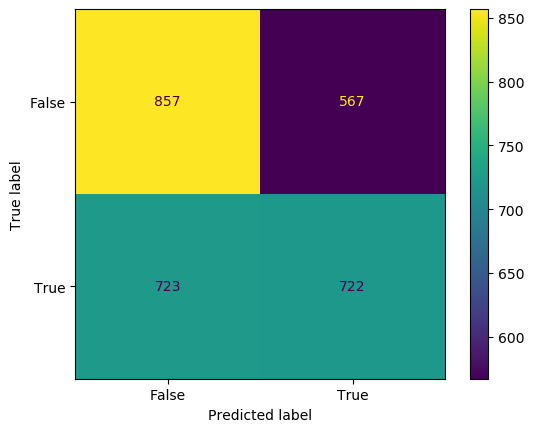

In [20]:
y_pred = sv_clf.predict(X_test)
print(f"score : {accuracy_score(y_test, y_pred)}")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

score : 0.7713489020564657


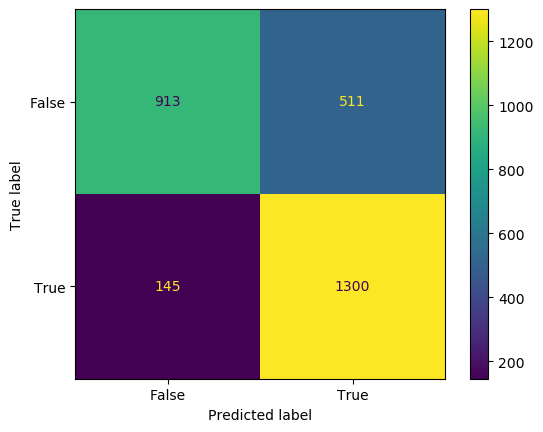

In [72]:
y_pred = sv_clf.predict(X_test)
print(f"score : {accuracy_score(y_test, y_pred)}")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [19]:
hyper_parameters = {'criterion' : ('gini', 'entropy', 'log_loss'), 
                    'n_estimators': np.arange(100,500,20), 
                    'max_depth' : [5,7,9,10],
                    'min_samples_split' : [2, 5]}

In [124]:
rf = RandomForestClassifier()
clf = GridSearchCV(rf, hyper_parameters)


NameError: name 'hyper_parameters' is not defined

In [22]:
clf.fit(X, y)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ('gini', 'entropy', 'log_loss'),
                         'max_depth': [5, 7, 9, 10],
                         'min_samples_split': [2, 5],
                         'n_estimators': array([100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340,
       360, 380, 400, 420, 440, 460, 480])})

In [47]:
rf_candidate = clf.best_estimator_

In [65]:
clf.best_params_

{'criterion': 'gini',
 'max_depth': 7,
 'min_samples_split': 2,
 'n_estimators': 180}

In [48]:
rf_candidate.fit(X, y)

RandomForestClassifier(max_depth=7, n_estimators=180)

In [24]:
clf.best_params_

{'criterion': 'gini',
 'max_depth': 7,
 'min_samples_split': 2,
 'n_estimators': 180}

In [29]:
clf.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_criterion', 'param_max_depth', 'param_min_samples_split', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [ ]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')

# Ramdon Forest Vanilla

In [131]:
X_train

,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,HomePlanet_Unknown,Side_P,Side_S,Side_Unknown,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,...,VIP_True,Deck,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,GroupId,Num
4696,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,5,35.0,1337.0,49.0,57.0,0.0,0.0,5007,951
5946,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,6,28.0,0.0,152.0,215.0,30.0,510.0,6308,1017
227,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,8,43.0,0.0,0.0,0.0,0.0,0.0,244,-1
3950,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1,65.0,0.0,0.0,0.0,0.0,0.0,4216,134
7674,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,6,18.0,0.0,0.0,19.0,751.0,4.0,8191,1320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,6,18.0,14.0,2.0,144.0,610.0,0.0,6076,988
5191,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,5,50.0,690.0,0.0,30.0,762.0,428.0,5537,1063
5390,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,5,22.0,158.0,0.0,476.0,0.0,26.0,5756,1194
860,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,5,34.0,379.0,0.0,1626.0,0.0,0.0,925,191


score : 0.7950505402579295


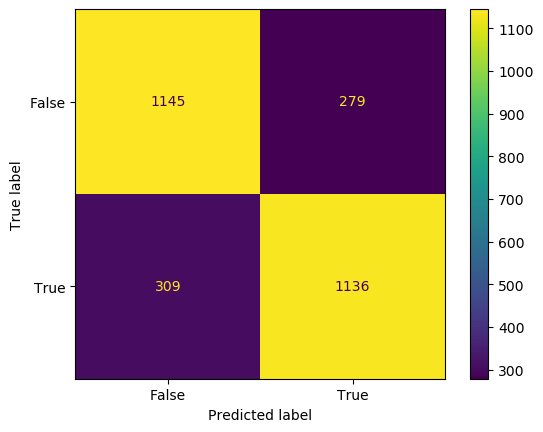

In [191]:
clf = RandomForestClassifier(n_estimators = 200 , max_depth=20, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(f"score : {accuracy_score(y_test, y_pred)}")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [192]:
std

array([0.01411719, 0.01477682, 0.0052999 , 0.00150791, 0.00528827,
       0.00539445, 0.00104346, 0.00295601, 0.00212164, 0.00301895,
       0.00119256, 0.07910984, 0.07852431, 0.00108831, 0.00104215,
       0.01381715, 0.01149917, 0.03912817, 0.0173921 , 0.02062215,
       0.04011861, 0.03577131, 0.01187467, 0.01025724])

Elapsed time to compute the importances: 0.023 seconds


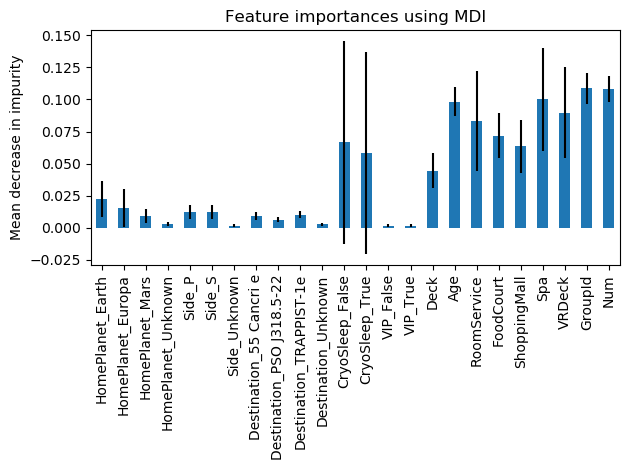

In [193]:
import time

import numpy as np
feature_names = [f"feature {i}" for i in range(X_train.shape[1])]
start_time = time.time()
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")
forest_importances = pd.Series(importances, index=X_train.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [194]:
feature_selection = X.columns[clf.feature_importances_>0.03]

score : 0.7800627396305333


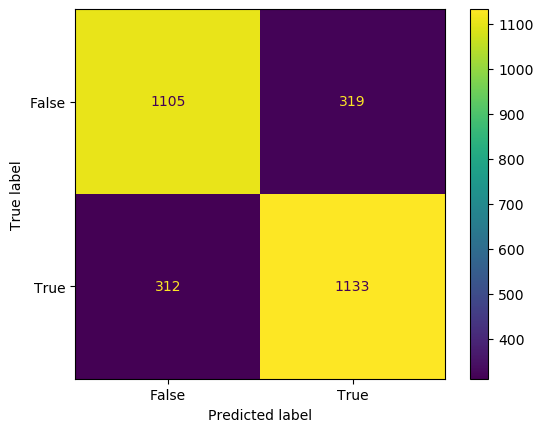

In [195]:
clf = RandomForestClassifier(n_estimators = 200 , max_depth=20, random_state=0)
clf.fit(X_train[feature_selection], y_train)
y_pred = clf.predict(X_test[feature_selection])
print(f"score : {accuracy_score(y_test, y_pred)}")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

# Submission

In [154]:
model = clf
model_name = "rf_2"

In [155]:
df_test = pd.read_csv("../res/test.csv")
df_test['Transported'] = False
y_submission = df_test[['PassengerId', 'Transported']]
df_test = pipe.transform(df_test)
X_test = df_test.drop(columns=['Transported'])
y_pred = clf.predict(X_test)
y_submission['Transported'] = y_pred

In [170]:
y_submission.to_csv(f'../res/submission/submission_{model_name}.csv', index= False)
with open(f'../res/submission/submission_{model_name}.txt','w') as file : 
    json.dump(model.get_params(), file)

In [168]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 20,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

In [140]:
y_pred

array([False, False,  True, ...,  True,  True,  True])

C:\Users\lopes\AppData\Local\Temp\ipykernel_19900\3723313744.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_submission['Transported'] = y_pred


,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [158]:
cat_features = ['HomePlanet']
categorical_transformer = OneHotEncoder(sparse_output = False, handle_unknown = 'ignore')
ct = ColumnTransformer(transformers = [('cat', categorical_transformer, cat_features)], 
                       remainder = 'passthrough', verbose_feature_names_out = False)


In [159]:
ct.set_output(transform='pandas')

ColumnTransformer(remainder='passthrough',
                  transformers=[('cat',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['HomePlanet'])],
                  verbose_feature_names_out=False)

In [160]:
df_pandas = ct.fit_transform(df_tr_vanilla)
df_pandas

,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,HomePlanet_nan,PassengerId,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0.0,1.0,0.0,0.0,0001_01,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,1.0,0.0,0.0,0.0,0002_01,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0.0,1.0,0.0,0.0,0003_01,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0.0,1.0,0.0,0.0,0003_02,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,1.0,0.0,0.0,0.0,0004_01,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,0.0,1.0,0.0,0.0,9276_01,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,1.0,0.0,0.0,0.0,9278_01,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,1.0,0.0,0.0,0.0,9279_01,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,0.0,1.0,0.0,0.0,9280_01,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


In [165]:
df_tr2 = df_tr.copy()

In [168]:
pipe

Pipeline(steps=[('Extract Group Id', ExtractGroupId()),
                ('Extract Cabing Info', ExtractCabinInfo()),
                ('transformation',
                 ColumnTransformer(transformers=[('Ordi Encode',
                                                  OrdinalEncoder(dtype=<class 'int'>,
                                                                 encoded_missing_value=-1,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['HomePlanet', 'CryoSleep',
                                                   'Deck', 'Side',
                                                   'Destination', 'VIP'])]))])

In [166]:
df_tr3 = pipe.fit_transform(df_tr2)

In [167]:
df_tr3

array([[1, 0, 1, 0, 2, 0],
       [0, 0, 5, 1, 2, 0],
       [1, 0, 0, 1, 2, 1],
       ...,
       [0, 0, 6, 1, 2, 0],
       [1, 0, 4, 1, 0, 0],
       [1, 0, 4, 1, 2, 0]])